In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 4)
import pyarrow

In [2]:
# read in methylated gene body cytosine counts
countsdata = sc.read_h5ad("mcg_210505_raw_genebody_blacklist_counts.h5ad")

# read in gene body cytosine coverage
covdata = sc.read_h5ad("mcg_210505_raw_genebody_blacklist_coverage.h5ad")

In [3]:
countsdf = countsdata.to_df() # turn countsdata AnnData obj into a pandas DataFrame
covdf = covdata.to_df() # turn covdata AnnData obj into a df
covdf.head(1)

geneslop2k,ENSG00000228794.12,FAM41C,ENSG00000283040,ENSG00000272438,ENSG00000230699,ENSG00000241180,LINC02593,SAMD11,NOC2L,KLHL17,...,MAPK8IP2,ARSA,ENSG00000289244.2,Y_RNA,ENSG00000286508,SHANK3,RNU6-409P,ENSG00000225929,ACR,ENSG00000254499
20210505-UMB5577-preAb-PFC-A09-L1_A1,0,0,0,11,2,2,0,14,12,3,...,21,0,5,0,0,32,0,8,8,8


## filter cells with no cell type

In [4]:
# read in csv file
cell_type = pd.read_csv("/u/project/cluo/heffel/BICAN3/Annotate/metadata_09122025.csv.gz").set_index("ID")
cell_type.head(1)

,newL1,newL2,newL3,fine_age_groups,age_groups,float_age,Interaction_count,updated_region,mCG/CG_chrL,mCH/CH_chrL,...,pairs_enzymeless_intra1kb,pairs_enzymeless_intra10kb,pairs_enzymeless_intra20kb,pairs_enzymeless_inter,pairs_dup_rate,high_coverage_pairs,allc_input_genome_coverage_dup,allc_input_genome_coverage_dedup,allc_input_mapped_bp_dup,allc_input_mapped_bp_dedup
ID,,,,,,,,,,,,,,,,,,,,,
20210111-1863-preAb-PFC-B12_A1,Exc,UL,L1-3-CUX2,adult,adult,31.0,101825.0,DFC,NaN,NaN,...,5183.0,4742.0,4499.0,1399.0,0.377175,81.0,44221255.0,44221255.0,45085203.0,45085203.0


In [5]:
covdata.obs["L2"] = cell_type["newL2"]
cell_type = pd.DataFrame(covdata.obs["L2"])
cell_type.head(1)

,L2
20210505-UMB5577-preAb-PFC-A09-L1_A1,MGE


In [6]:
no_cell_type = cell_type[cell_type["L2"].isna()].index

In [7]:
# drop rows w no cell type
covdf = covdf.drop(index=no_cell_type)
countsdf = countsdf.drop(index=no_cell_type)

## filter by mean feature coverage

In [8]:
mean_cell_cov = covdf.mean(axis=1) # Series of mean cell coverage
mean_cell_cov.head(1)

20210505-UMB5577-preAb-PFC-A09-L1_A1    6.112561
dtype: float64

(0.0, 20.0)

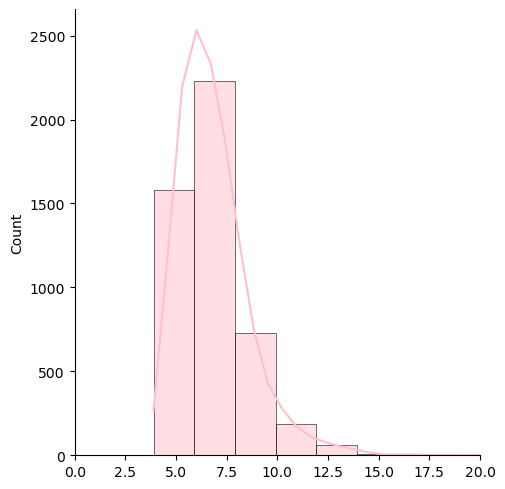

In [9]:
# plot mean cell coverage
sns.displot(mean_cell_cov, kde=True, binwidth=2, color='pink')
plt.xlim(left=0, right=20)

In [10]:
mean_feat_cov = covdf.mean(axis=0) # Series of mean feature coverage
mean_feat_cov.head(1)

geneslop2k
ENSG00000228794.12    1.169029
dtype: float64

(-5.0, 50.0)

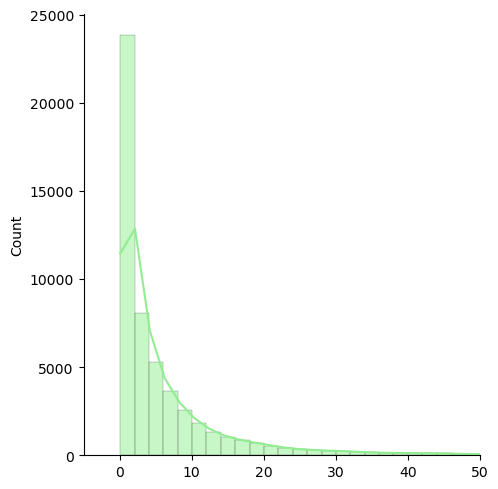

In [11]:
# plot mean feature coverage
sns.displot(mean_feat_cov, kde=True, binwidth=2, color='lightgreen')
plt.xlim(left=-5, right=50)

In [12]:
# create DataFrame from the mean feature coverage Series
mean_feat_cov = pd.DataFrame(mean_feat_cov)
mean_feat_cov.head(1)

,0
geneslop2k,
ENSG00000228794.12,1.169029


In [13]:
# create a threshold list which indexes all features with mean coverage < 50
threshold = mean_feat_cov[mean_feat_cov[0] < 50].index

In [14]:
# drop columns according to threshold
covdf = covdf.drop(columns=threshold)
countsdf = countsdf.drop(columns=threshold)

covdf.shape # need ~5-10x as many cells as features (bc of dimensionality issues), so work with 670 features for now. 

(4798, 819)

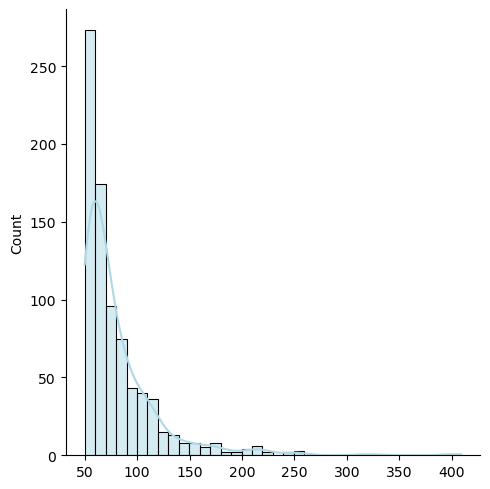

In [15]:
sns.displot(covdf.mean(axis=0), binwidth=10, color="lightblue", kde=True) # distribution of feature coverage after filtering

## plot feature mean x gene length

In [16]:
# read in csv file
gene_length = pd.read_csv("/u/project/cluo/heffel/BICAN/ref/geneslop2k.bed", sep="\t")
gene_length.head(1)

,#chr,start,end,gene
0,chr1,9868,16409,ENSG00000290825.1


In [17]:
# set index as the gene name
gene_length = gene_length.set_index("gene")
gene_length.head(1)

,#chr,start,end
gene,,,
ENSG00000290825.1,chr1,9868,16409


In [18]:
# create a new column "length" that has the length (end - start)
gene_length["length"] = gene_length["end"] - gene_length["start"]
gene_length.head(1)

,#chr,start,end,length
gene,,,,
ENSG00000290825.1,chr1,9868,16409,6541


In [19]:
# create readable gene ID's (ie: FAM41C as opposed to ENSG00000230368.2)
conv_table = pd.read_csv("/u/project/cluo/heffel/BICAN/ensg_to_symbol.tsv", sep="\\t").set_index("ENSG").to_dict()["Symbol"]

# copy gene ID's to gene_length
gene_length.index = gene_length.index.map(lambda x: conv_table.get(x, x))
gene_length.head()

,#chr,start,end,length
gene,,,,
ENSG00000290825.1,chr1,9868,16409,6541
ENSG00000223972.6,chr1,10009,15670,5661
WASH7P,chr1,12403,31570,19167
MIR6859-1,chr1,15368,19436,4068
MIR1302-2HG,chr1,27553,33109,5556


In [20]:
gene_mean = covdf.mean() # caclulate mean methylation for each gene
gene_mean = pd.DataFrame(gene_mean) # turn Series into DataFrame
gene_mean = gene_mean.rename(columns={0: "mean"}) # rename column zero to mean
gene_mean.head(1)

,mean
geneslop2k,
PRKCZ,82.694873


In [21]:
# find the common indices
common_indices = gene_length.index.intersection(gene_mean.index)

# filter gene_length using the common indices
gene_length = gene_length.loc[common_indices]
gene_length.tail(1)

,#chr,start,end,length
ENSG00000188511.14,chr22,49412523,49659542,247019


In [22]:
(gene_mean.index == gene_length.index).all() # check that indices match

np.True_

In [23]:
# add gene length to the gene mean DataFrame
gene_mean["length"] = gene_length["length"].reindex(gene_mean.index)
gene_mean.head(1)

,mean,length
geneslop2k,,
PRKCZ,82.694873,138985


<Axes: xlabel='length', ylabel='mean'>

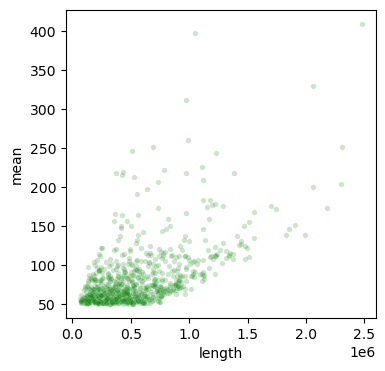

In [24]:
# scatter plot
sns.scatterplot(data=gene_mean, x="length", y="mean", alpha=0.2, s=15, color="green", legend=False)

## masks

In [25]:
# dict data = {"name": [list, list], }
low_cov = [5, 10, 25, 50, 55, 60, 70, 75, 100, 150, 200] # list of coverage thresholds

count_ls = []
percent_ls = []

for i in low_cov:
    mask = covdf < i # mask of positions with coverage < i
    count = covdf[mask].isna().sum().sum() # count number positions w coverage >= i
    percent = (count / (covdf.shape[0] * covdf.shape[1])) # percent positions w coverage >= i
    
    mask.to_parquet(f'mask{i:03d}.parquet') # save mask
    
    count_ls.append(count) # append count to the count list
    percent_ls.append(percent) # append percent to the percent list
    
    print(f"{i:03d} {count:,>3}, {percent:.2%>3} with >={i} coverage values ({1 - percent:.2%} data to be imputed)")

005: 3,915,754, 99.65% with >5 coverage values (0.35% data to be imputed)
010: 3,909,688, 99.49% with >10 coverage values (0.51% data to be imputed)
025: 3,808,074, 96.91% with >25 coverage values (3.09% data to be imputed)
050: 2,918,539, 74.27% with >50 coverage values (25.73% data to be imputed)
055: 2,657,356, 67.62% with >55 coverage values (32.38% data to be imputed)
060: 2,396,602, 60.99% with >60 coverage values (39.01% data to be imputed)
070: 1,910,775, 48.63% with >70 coverage values (51.37% data to be imputed)
075: 1,694,135, 43.11% with >75 coverage values (56.89% data to be imputed)
100: 914,461, 23.27% with >100 coverage values (76.73% data to be imputed)
150: 300,807, 7.65% with >150 coverage values (92.35% data to be imputed)
200: 122,919, 3.13% with >200 coverage values (96.87% data to be imputed)


In [26]:
info = {"threshold": low_cov, "counts": count_ls, "percent": percent_ls} # create a dict
info = pd.DataFrame(info) # turn dict into df

<Axes: xlabel='threshold', ylabel='percent'>

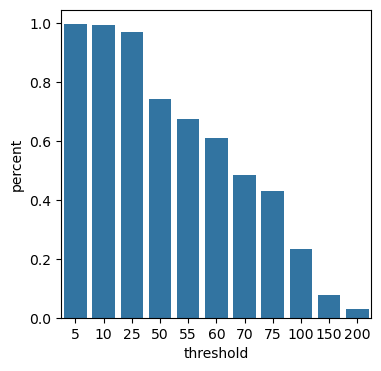

In [27]:
sns.barplot(data=info, x="threshold", y="percent") # plot diff thresholds percent of data kept

## fractions of gene body methylation

In [28]:
frac = countsdf / covdf # divide to get methylation fraction
frac.head(1)

geneslop2k,PRKCZ,ENSG00000157933.11,PRDM16,ENSG00000162591.17,AJAP1,NPHP4,ENSG00000097021.21,ENSG00000171735.20,ENSG00000142599.20,CASZ1,...,EFCAB6,PARVB,PRR5-ARHGAP8,PHF21B,CELSR1,GRAMD4,TBC1D22A,ENSG00000224271.8,TAFA5,ENSG00000188511.14
20210505-UMB5577-preAb-PFC-A09-L1_A1,0.930233,0.90625,0.902299,0.959459,0.965517,1.0,0.75,0.935961,0.931818,0.704545,...,0.861538,0.791667,0.779412,0.775,0.966667,0.705882,0.947368,0.95122,0.960265,0.958763


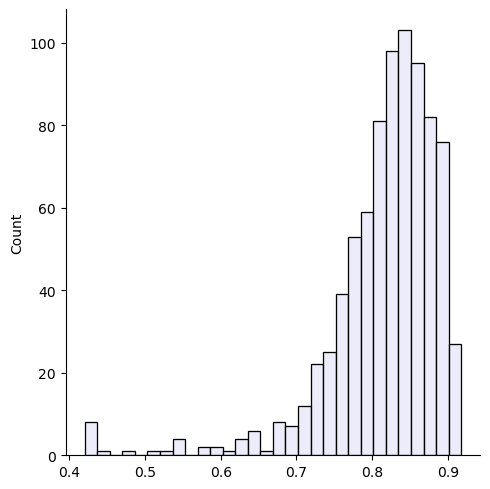

In [29]:
sns.displot(frac.mean(), bins=30, color="lavender") # plot distribution of data

## create new AnnData object

In [30]:
len(covdata.obs), len(covdata.var)

(5618, 53100)

In [31]:
obs = covdata.obs.drop(no_cell_type) # drop rows for cells without a cell type
var = covdata.var.drop(threshold, axis=0) # drop rows according to threshold

len(obs), len(var)

(4798, 819)

In [32]:
# create new anndata obj
adata = ad.AnnData(X=frac)

# copy over the obs & var
adata.obs = obs
adata.var = var

In [33]:
methyl_df = adata.to_df() # new DataFrame

In [34]:
print(f"NaN's:    {adata.to_df().isna().sum().sum():>5}")
print(f"'s:      {(adata.to_df()==0).sum().sum():>5}")
print(f"cells:    {adata.shape[0]:>5}")
print(f"features: {adata.shape[1]:>5}")

NaN's:     7651
's:        766
cells:     4798
features:   819


In [35]:
adata.write_h5ad("mcg_210505_4798x819_qc.h5ad") # write adata file